# Playing Time Influenced by Gender as a Predictor for Game Newsletter Subscription
By Group 23 (Aayush, Kathleen, QingYou, Gordon) 

## Introduction
#### Background:

Frank Wood is leading a research group in computer science at UBC and collecting data about the ways people play video games by hosting a MineCraft server that automatically tracks player analytics. The group needs to strategically target recruitment efforts for players and ensure that their computational resources are sufficient to support their player base. They've accumulated the `players` dataset which we will work with to draw findings about player activity based on demographics.

#### Question

**General Question:**

What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types? (Question 1)

**Specific Interpretation:**

To what extent can a player's played hours and age predict subscription status in the players dataset? 

#### Dataset Overview

To answer this question, we will use the `players` dataset to create a KNN classifier that predicts subscription status. 

The `players` dataset includes 196 observations and 7 variables describing player demographic information and activity on the server. The following variables are included in the full dataset:

| Variable | Type | Description |
|--------|----|-----------|
| `experience` | character | Player's skill level |
| `subscribe` | logical | Indicates whether player subscribes to a game-related newsletter |
| `hashedEmail` |character | Unique identifier for each player (hashed) |
| `played_hours` | numeric | Total accumulated play time on the server in hours |
| `name` | character | Player's name |
| `gender` | character | Gender |
| `Age` | numeric | Player's age |

To answer our question, we are only interested in `subscribe`, `played hours`, and `age`.

**Response variable:**
* `subscribe`: Indicates whether a player is subscribed to a game-related newsletter, each value can be interpreted as one of two classes. 

**Explanatory variables:**
* `played hours`: The total number of hours a player has logged on the server. This is reliable as it is automatically tracked.
* `age`: The self-reported age in years of a player. There could be response bias or incorrect information in this data.

Age has two NA values. We will handle this by dropping those observations.

## Methods and Results

We will be training a KNN classifier off our player data in order to see if we can predict subscription status based on a player's played hours and age.

#### Step 1: Loading Libaries and Data

We'll first load some libraries that we'll (absolutely or possibly) need. Then we'll read in our players dataset using a URL so that this project is able to run on different devices.

In [9]:
library(tidyverse)
library(repr)
library(tidymodels)
library(themis)
library(RColorBrewer)
options(repr.matrix.max.rows = 6)

In [4]:
players <- read_csv('https://raw.githubusercontent.com/kathleenramsey/dsci100_group23/main/Project%20Planning%20Players.csv')
players

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience subscribe
1   Pro         TRUE    
2   Veteran     TRUE    
3   Veteran    FALSE    
⋮   ⋮          ⋮        
194 Amateur    FALSE    
195 Amateur    FALSE    
196 Pro         TRUE    
    hashedEmail                                                     
1   f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d
2   f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9
3   b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28
⋮   ⋮                                                               
194 d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb
195 f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436
196 d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11
    played_hours name      gender            Age
1   30.3         Morgan    Male               9 
2    3.8         Christian Male              17 
3    0.0         Blake     Male              17 
⋮   ⋮            ⋮         ⋮                 ⋮  
194 0.0          Dylan     Prefer not to say 17 
195 2.3          Harlow    Male              17 
196 0.2          Ahmed     Other             NA

#### Step 2: Wrangling and Preparing Data

After loading in the data, we'll tidy it by changing the datatypes of `experience`, `gender`, and `subscribe` into factor variables. We'll also go on and remove the two rows that have missing `Age` variables.

In [6]:
players_tidy <- players |>
    mutate(subscribe = as_factor(subscribe)) |>
    filter(is.na(Age) == FALSE) |>
    select(Age, played_hours, subscribe)
players_tidy

Age played_hours subscribe
1    9  30.3         TRUE     
2   17   3.8         TRUE     
3   17   0.0         FALSE    
⋮   ⋮   ⋮            ⋮        
192 22  0.3          FALSE    
193 17  0.0          FALSE    
194 17  2.3          FALSE

#### Step 3: Summary of Exploratory Data

Below we are getting some statistics on the variables from our players dataset we will use for our analysis. We can see roughly 3/4 of the players are subscribed to a game-related newspaper. We can see that the mean age of the players are around 20 and that there is a strong skew to low values in `played_hours` with many players having 0 played hours.

In [17]:
subscription_proportion <- players_tidy |>
    group_by(subscribe) |>
    summarize(count = n()) |>
    mutate(percentage = (count / sum(count)) * 100)
subscription_proportion

age_summary <- players_tidy |>
    summarize(mean = mean(Age, na.rm = TRUE),
              sd = sd(Age, na.rm = TRUE),
              median = median(Age, na.rm = TRUE),
              min = min(Age, na.rm = TRUE),
              max = max(Age, na.rm = TRUE))
age_summary

played_hours_summary <- players_tidy |>
    summarize(mean = mean(played_hours, na.rm = TRUE),
              sd = sd(played_hours, na.rm = TRUE),
              median = median(played_hours, na.rm = TRUE),
              min = min(played_hours, na.rm = TRUE),
              max = max(played_hours, na.rm = TRUE))
played_hours_summary

subscribe count percentage
1 FALSE      52   26.80412  
2 TRUE      142   73.19588

mean     sd       median min max
1 20.52062 6.174667 19     8   50

mean     sd       median min max  
1 5.904639 28.49793 0.1    0   223.1

#### Step 4: Exploratory Visualizations

We'll explore some vizualisations to better understand our variables and their relationships with each other. 

* **Figure 1: `played_hours` distribution**

The histogram below shows what we mentioned earlier about the pretty substantial inbalance in `played_hours` amongst players. A huge majority of players have single-digit and near 0 hours played. Included in the plot is the distinction between those who are subscirbed and those who aren't subscribed to a game-related newspaper. We can see that ,unsurprisingly, most of the those not subscribed have lower or no hours.

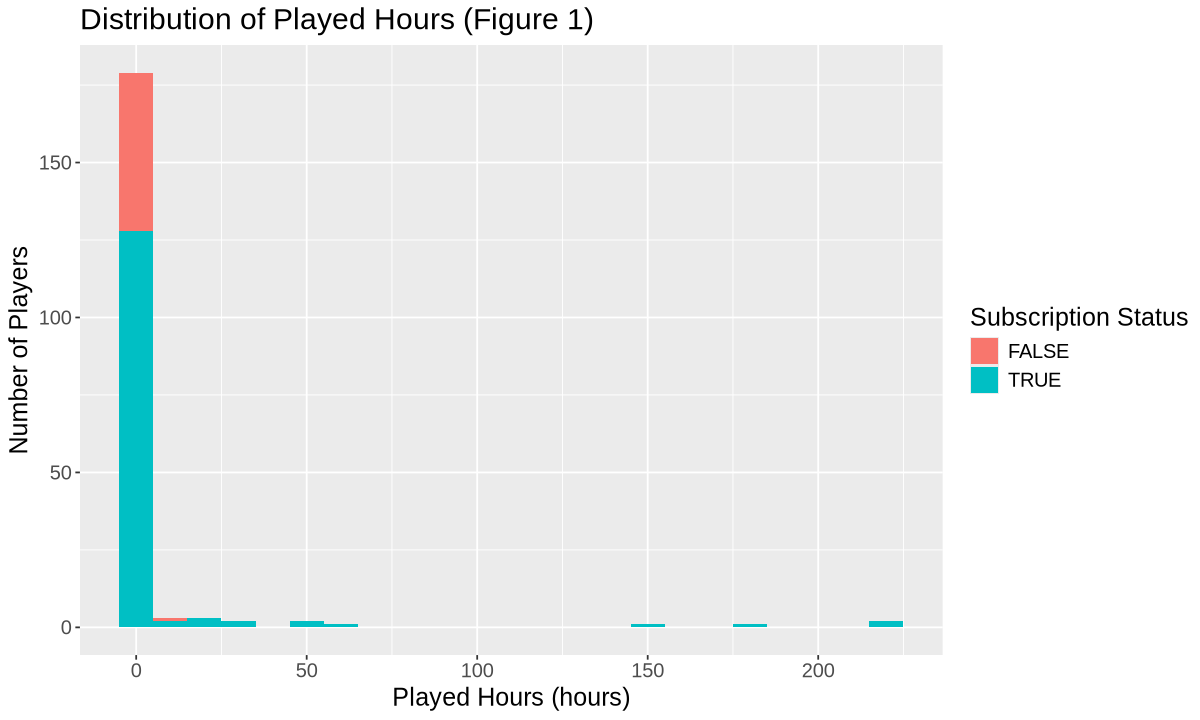

In [48]:
options(repr.plot.height = 6, repr.plot.width = 10)

player_hist <- players_tidy |>
    ggplot(aes(x=played_hours, fill=subscribe)) +
    geom_histogram(binwidth=10) +
    labs(x='Played Hours (hours)',
         y='Number of Players',
         fill='Subscription Status',
         title = 'Distribution of Played Hours (Figure 1)') +
    theme(text = element_text(size = 15)) 
player_hist

* **Figure 2: Distribution of `Age`**

The histogram below shows us the distribution of the age of the players. We can see that most of our players are around their mid-teens to early twenties. There is no distinct pattern visible here with how much of each group subscribes/isn't subscribed. 

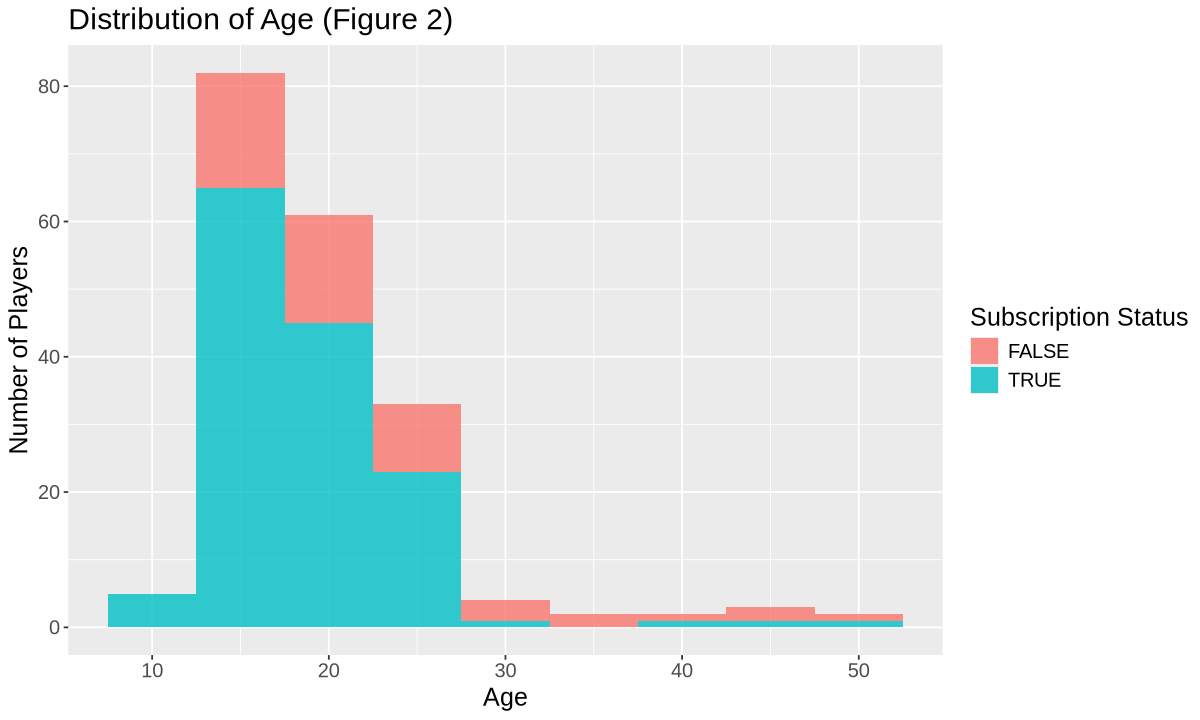

In [47]:
options(repr.plot.height = 6, repr.plot.width = 10)

age_hist <- players_tidy |>
    ggplot(aes(x=Age, fill=subscribe)) +
    geom_histogram(binwidth=5, alpha = 0.8) +
    labs(x='Age',
         y='Number of Players',
         fill='Subscription Status',
         title = 'Distribution of Age (Figure 2)') +
    theme(text = element_text(size = 15)) 
age_hist

* **Figure 3: `played_hours` vs `Age` Scatterplot**

Looking at the plot below, we can see that there is no clear linearity or dominant relationship between `Age` and `played_hours`. There is also no strong pattern of which observations are more likely to subscribe or not subscribe which is concerning. We see a peak around the mid-teens to early twenties where we have our highest played hours. But other than that most of observations have lower played hours which we mentioned in figure 1.

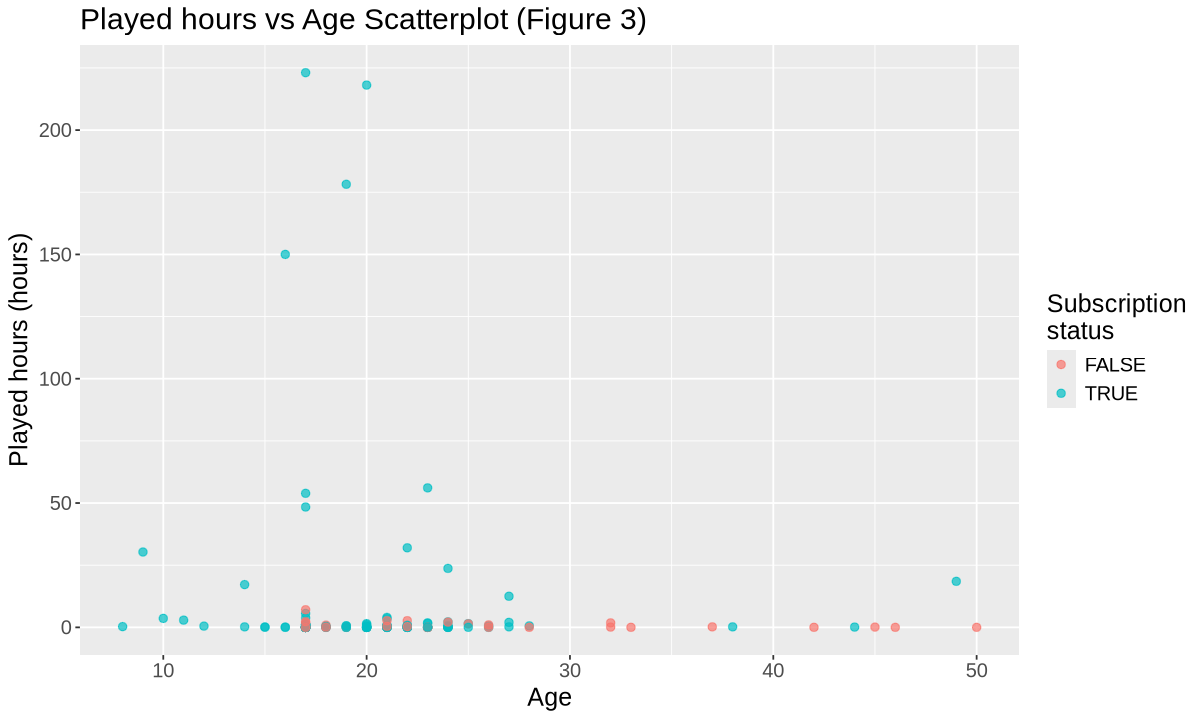

In [20]:
options(repr.plot.height = 6, repr.plot.width = 10)

played_hours_vs_age <- players_tidy |>
    ggplot(aes(x = Age, y = played_hours, color = subscribe)) +
        geom_point(alpha = 0.7, size = 2) +
        labs(title = "Played hours vs Age Scatterplot (Figure 3)",
             color = "Subscription\nstatus",
             x = "Age",
             y = "Played hours (hours)") +
        theme(text = element_text(size = 15))
played_hours_vs_age

#### Step 5: Data Analysis

The code below follows the following steps: 
* Set the seed to ensure reproduceability for the split and the vfold.
* Split our data into a training and testing split so we can accurately assess our predictive model later (prop = 0.75).
* Create a tibble containing the range different k-values to tune our KNN classification model.
* Create vfold with v = 5 to gage best k-value.
* Create temporary tuning KNN classification model.
* Create recipe containing our variables and training data, scaling/centering variables along the way.
* Combine using workflow along with `tune_grid`.
* Collect metrics, plot accuracy, and get best k-value.

The results show that the best k-value is k = 25 with an accuracy of 0.745....

[1] 2

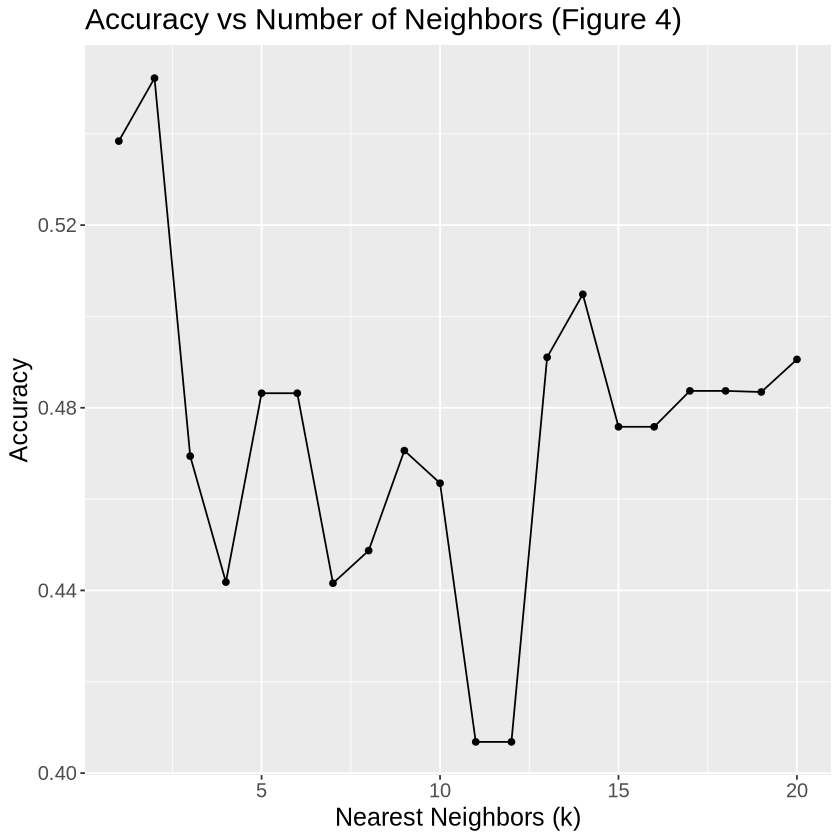

In [13]:
set.seed(23) 

players_split <- initial_split(players_tidy, prop = 0.75, strata = subscribe)
players_train <- training(players_split)
players_test <- testing(players_split)

k_vals <- tibble(neighbors = c(1:20))

knn_vfold <- vfold_cv(players_train, v = 5, strata = subscribe)

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_recipe <- recipe(subscribe ~ Age + played_hours, data = players_train) |>
    step_upsample(subscribe, over_ratio = 1, skip = TRUE) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

knn_workflow <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = knn_vfold, grid = k_vals)

knn_metrics <- knn_workflow |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean))

cross_val_plot <- knn_metrics |>
    ggplot(aes(x = neighbors, y = mean)) +
        geom_point() +
        geom_line() +
        labs(title = "Accuracy vs Number of Neighbors (Figure 4)",
             x = "Nearest Neighbors (k)",
             y = "Accuracy") + 
        theme(text = element_text(size = 15))
cross_val_plot

best_k <- knn_metrics |>
    arrange(desc(mean)) |>
    select(neighbors) |>
    slice(1) |>
    pull()
best_k

Using the optimal k-value found earlier, we'll now train our new classifier model accordingly and assess its effectiveness.
* Create new model spec with `best_k` as the k_value.
* Combine model spec with our recipe and data.
* Apply model onto test set and bind predictions.
* Assess acccuracy and create confusion matrix for further analysis.

Looking at our results, we can see that our overall accuracy is around 0.735. Now looking at the accuracy alone cannot accurately (see what I did there) describe the model's overall effectiveness. Looking at the confusion matrix, we'll see that our model had made no `FALSE` predictions which goes back to our concerns from figures 1-3.

In [14]:
set.seed(23)

best_k_model <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_workflow2 <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(best_k_model) |>
    fit(data = players_train)

player_test_pred <- knn_workflow2 |>
    predict(players_test) |>
    bind_cols(players_test) 
player_test_pred

player_pred_accuracy <- player_test_pred |>
    metrics(truth = subscribe, estimate = .pred_class) 
player_pred_accuracy

players_pred_matrix <- player_test_pred |>
        conf_mat(truth = subscribe, estimate = .pred_class)
players_pred_matrix

.pred_class Age played_hours subscribe
1  TRUE         9  30.3         TRUE     
2  FALSE       17   0.0         FALSE    
3  FALSE       17   0.1         TRUE     
⋮  ⋮           ⋮   ⋮            ⋮        
47 TRUE        20  0.0          TRUE     
48 TRUE        22  0.3          FALSE    
49 TRUE        17  2.3          FALSE

.metric  .estimator .estimate 
1 accuracy binary      0.3265306
2 kap      binary     -0.2622951

          Truth
Prediction FALSE TRUE
     FALSE     4   24
     TRUE      9   12

#### Step 6: Visualizing Our Analysis

To kinda visualize our analysis, we've created this visual (taken from the textbook). The colored regions represent the regions where our KNN classifier will predict `TRUE`.

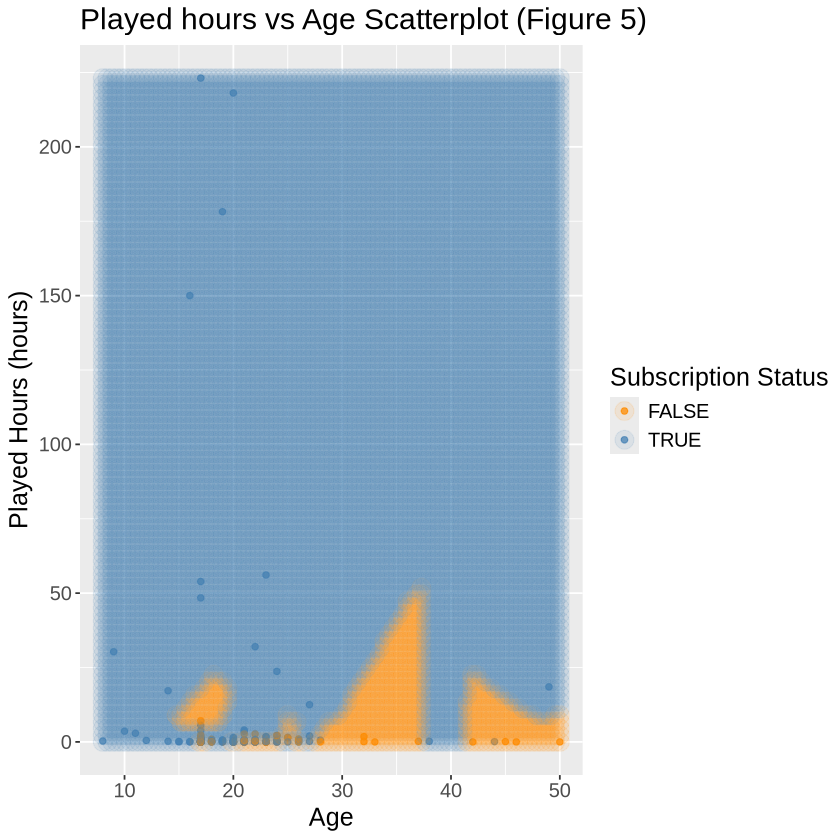

In [16]:
# create the grid of area/smoothness vals, and arrange in a data frame
age_grid <- seq(min(players_tidy$Age),
                max(players_tidy$Age),
                length.out = 100)
ph_grid <- seq(min(players_tidy$played_hours),
                max(players_tidy$played_hours),
                length.out = 100)
asgrid <- as_tibble(expand.grid(Age = age_grid,
                                played_hours = ph_grid))

# use the fit workflow to make predictions at the grid points
knnPredGrid <- predict(knn_workflow2, asgrid)

# bind the predictions as a new column with the grid points
prediction_table <- bind_cols(knnPredGrid, asgrid) |>
  rename(subscribe = .pred_class)

# plot:
# 1. the colored scatter of the original data
# 2. the faded colored scatter for the grid points
wkflw_plot <-
  ggplot() +
  geom_point(data = players_tidy,
             mapping = aes(x = Age,
                           y = played_hours,
                           color = subscribe),
             alpha = 0.75) +
  geom_point(data = prediction_table,
             mapping = aes(x = Age,
                           y = played_hours,
                           color = subscribe),
             alpha = 0.1,
             size = 5) +
  labs(color = "Subscription Status",
       x = "Age",
       y = "Played Hours (hours)",
       title = "Played hours vs Age Scatterplot (Figure 5)") +
  scale_color_manual(values = c("darkorange", "steelblue")) +
  theme(text = element_text(size = 15))

wkflw_plot

### Summary of Results (Accuracy):

1. **Accuracy for the full dataset (all players): 0.617** (61.7%)

2. **Accuracy or male players: 0.75** (75%)

3. **Accuracy for gender-diverse players: 0.77** (77%)

### Interpretation:
- The model performs reasonably well for the full dataset with an accuracy of 61.7%.
- The model performs better for male players, achieving an accuracy of 75%.
- The model works best for gender-diverse players, with an accuracy of 77%. This suggests that the model is more accurate at predicting subscription behavior for gender-diverse players compared to male players.

5.creates a visualization of the analysis


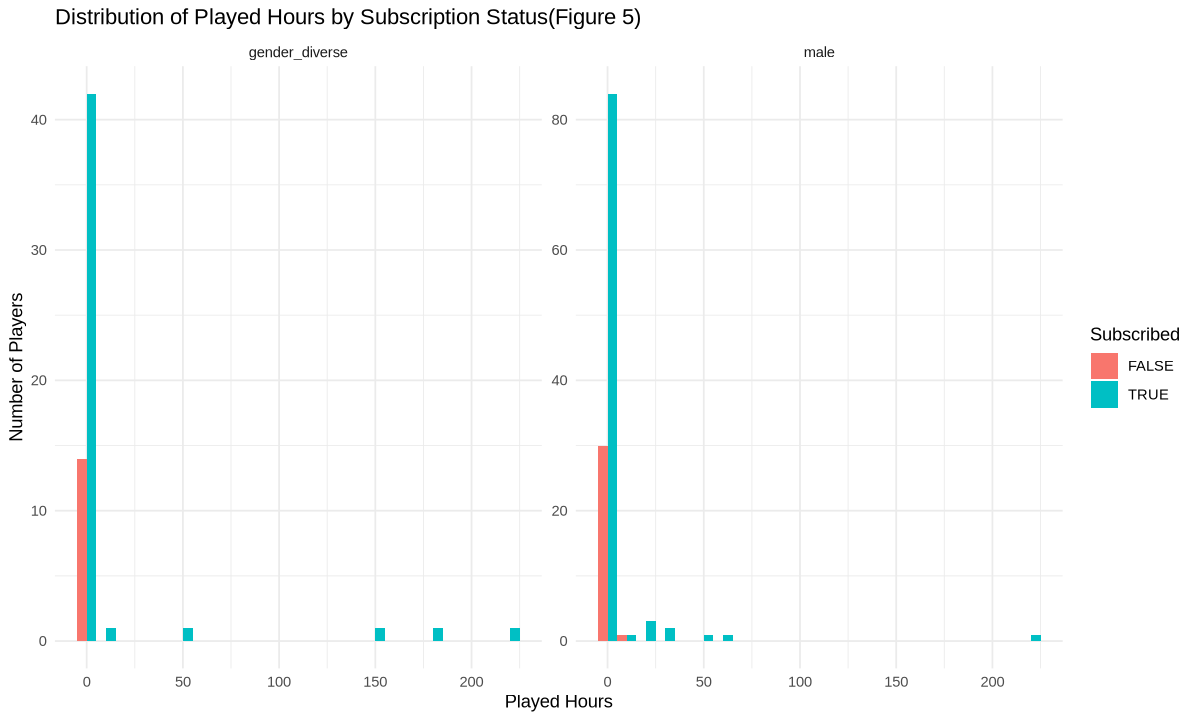

In [45]:
options(repr.plot.height = 6, repr.plot.width = 10)
# Combine all player data for the plot
players_full <- players |>
  select(subscribe, played_hours, gender) |>
  filter(gender != 'Prefer not to say') |>
  mutate(gender = if_else(gender == "Male", "male", "gender_diverse")) |>
  mutate(subscribe = as.factor(subscribe))

# Create a histogram for all players
ggplot(players_full, aes(x = played_hours, fill = subscribe)) +
  geom_histogram(binwidth = 10, position = "dodge") +
  labs(
    title = "Distribution of Played Hours by Subscription Status(Figure 5)",
    x = "Played Hours",
    y = "Number of Players",
    fill = "Subscribed"
  ) +
  theme_minimal() +
  facet_wrap(~gender, scales = "free") 


### Explanation:
- **`geom_histogram()`**: Creates the histogram, where `binwidth` specifies the width of each bar in the histogram.
- **`position = "dodge"`**: This separates the bars for players who subscribed and those who did not.
- **`facet_wrap(~gender)`**: This creates separate histograms for male and gender-diverse players, allowing for easy comparison between the groups.
- **`labs()`**: Adds titles and axis labels to the plot.

This visualization will help us see how the distribution of played hours differs between subscribed and non-subscribed players and also how this pattern might vary between male and gender-diverse players.

## Discussion

### Summary of Findings:
The KNN models trained on different groups of players showed that total played hours is an important factor in predicting whether a player subscribes to a game-related newsletter. Players who spend more time playing the game are more likely to subscribe to the newsletter. This trend was observed in both male and gender-diverse players, though the model's performance varied across these groups.

- **For all players (combined):** The model had an accuracy of 61.7%. This suggests that total played hours can provide a moderate prediction of subscription likelihood across the full player base.
- **For male players:** The accuracy was 75%, indicating that played hours are an important predictor, but the model's performance is more reliable for male players than for the full dataset.
- **For gender-diverse players:** The accuracy was 77%, suggesting that played hours are a particularly strong predictor for this group. Gender-diverse players might have a clearer connection between their in-game time and subscription behavior compared to male players.

### Is this what you expected to find?

- **Expected Outcomes**: We thought that total played hours would be an important factor for predicting newsletter subscriptions because players who play more may want to get more information, like newsletters. This fits with our expectations, as time spent in the game likely shows an interest in staying informed about game updates, events, and other content.
  
- **Unexpected Outcomes**: The difference in model performance between male and gender-diverse players was surprising. We thought played hours would be useful for both groups, but the model did better for gender-diverse players. This means that their behavior in the game might match their subscription choices more clearly. It also shows that gender might affect not just the chance of subscribing but also how players react to game marketing. This could depend on their interests, gaming habits, or how much they engage with the game community.

The lower accuracy for male players suggests that there are other factors—possibly not in this dataset—that influence their decision to subscribe to newsletters. It may also mean that male players’ subscription behavior is less linked to in-game hours, or that including other features (like experience or age) would improve the model for this group.

In conclusion, the analysis showed that played hours is an important predictor for newsletter subscriptions, but it works better for gender-diverse players. This means that while played hours are helpful, exploring more features and improving the model (especially for male players) could make predictions more accurate for all players. Gender differences in how played hours predict subscription behavior could also be interesting to study further, as they may help us understand player behavior and improve marketing strategies.

### What impact could such findings have?

Our findings and results emphasize how crucial it is to take gender diversity into consideration when developing predictive models for user behavior analysis:

**Targeted Marketing Strategies:** Since we have shown that subscription behaviour is more predictable for gender-diverse and male players, companies can use this insight to create effective advertisements aimed at these players without over-targeting or overlooking certain groups.

**Gaming Product Design:** Game developers can explore why gender-diverse and male users like their game and newsletter and then use those discoveries to create more inclusive, engaging game features.

**Encourages Inclusive Data Science Methods:** Our research highlights the importance of including a wide range of demographics groups when collecting data in order to gain a more complete picture of user behaviour.

**Discovering Hidden Model Biases:** The discrepancy between our overall accuracy (61.7%), male-only accuracy (75%), and gender-diverse accuracy (77%) demonstrates that certain subgroups may underperform or excel with specific models. This shows that data analysis should always involve subgroup analysis when evaluating accuracy of a given model.

### What future questions could this lead to?

Our findings and results open the door to a variety of thought-provoking questions that require further analysis to answer such as:

1. Why is the subscription predictive accuracy so low for the complete dataset? If we used models for each subgroup of gender, would all of them produce greater accuracies?

2. What reasons do different genders value the game and newsletter for? Is it the actual content of the game? Are certain genders more likely to develop an emotional connection? For instance, some players may feel a stronger emotional attachment because of the inclusivity and representation in the game and the community. Are certain genders more likely to rely on the newsletter or external sources for updates on the game?

3. How might other factors and their interactions with gender affect subscription predictability? For example, what would change if we also used experience or age as predictors?

4. How would our results change in larger datasets or different types of games?
